# Model Training Pipeline for Capstone Project - Training Pretrained Unet and DeeplabV3 Models
This document explains the full training workflow used for our CloudSEN12+ cloud-segmentation model.
The goal is to make the notebook readable and self-contained so that any team member can understand and extend it.

# Model Training

## 1. Environment Setup

We install rasterio, which is required to read multispectral GeoTIFF tiles (Sentinel-2 bands + label masks).
CloudSEN12+ uses 13 spectral bands, so rasterio is essential for loading them correctly.

In [ ]:
!pip install rasterio

In [ ]:
# ============================================
# Install required libraries for training
# ============================================

!pip install --quiet segmentation-models-pytorch==0.3.3
!pip install --quiet pytorch-lightning==2.2.4
!pip install --quiet torchmetrics==1.4.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 26.2 MB/s eta 0:00:00


## 2. Directory Structure and Data Paths

The code defines the base dataset path and constructs:

train/imgs/

train/masks/

val/imgs/

val/masks/

test/imgs/

test/masks/

In [ ]:
# ============================================
# Mount Google Drive
# ============================================

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

# Base dataset directory (update if different)
DATA_ROOT = "/content/drive/MyDrive/CloudSEN12_Plus_13band_4Class"

assert os.path.exists(DATA_ROOT), f" Dataset not found at: {DATA_ROOT}"

print("✔ Drive mounted")
print("✔ Dataset directory:", DATA_ROOT)


Mounted at /content/drive
✔ Drive mounted
✔ Dataset directory: /content/drive/MyDrive/CloudSEN12_Plus_13band_4Class


In [ ]:
# ============================================
# Dataset Folder Structure Configuration
# ============================================

# ROOT DATASET DIRECTORY (confirmed in previous cell)
# Change ONLY if your folder name differs
DATA_ROOT = "/content/drive/MyDrive/CloudSEN12_Plus_13band_4Class"

# TRAIN
TRAIN_IMG_DIR  = f"{DATA_ROOT}/train/images"
TRAIN_MASK_DIR = f"{DATA_ROOT}/train/masks"

# VALIDATION
VAL_IMG_DIR    = f"{DATA_ROOT}/val/images"
VAL_MASK_DIR   = f"{DATA_ROOT}/val/masks"

# TEST
TEST_IMG_DIR   = f"{DATA_ROOT}/test/images"
TEST_MASK_DIR  = f"{DATA_ROOT}/test/masks"

# ---------- SAFETY CHECKS ----------
import os

for p in [TRAIN_IMG_DIR, TRAIN_MASK_DIR, VAL_IMG_DIR, VAL_MASK_DIR, TEST_IMG_DIR, TEST_MASK_DIR]:
    assert os.path.exists(p), f" MISSING FOLDER: {p}"

print("✔ Dataset structure verified")
print(f"Train tiles: {len(os.listdir(TRAIN_IMG_DIR))} images, {len(os.listdir(TRAIN_MASK_DIR))} masks")
print(f"Val tiles:   {len(os.listdir(VAL_IMG_DIR))} images, {len(os.listdir(VAL_MASK_DIR))} masks")
print(f"Test tiles:  {len(os.listdir(TEST_IMG_DIR))} images, {len(os.listdir(TEST_MASK_DIR))} masks")

✔ Dataset structure verified
Train tiles: 1083 images, 1083 masks
Val tiles:   192 images, 192 masks
Test tiles:  225 images, 225 masks


# Integrity Check on the Dataset

We verify the shapes of images and corresponding masks. Also We check the split of train, validate and Test.

In [ ]:
# ============================================
# Quick Integrity Check on Training Tiles
# ============================================

import glob
import rasterio
import numpy as np

# Collect image + mask file paths
imgs  = sorted(glob.glob(f"{TRAIN_IMG_DIR}/*.tif"))
masks = sorted(glob.glob(f"{TRAIN_MASK_DIR}/*.tif"))

print(f"Training tiles: {len(imgs)} images, {len(masks)} masks")

assert len(imgs) == len(masks), " Mismatch between image and mask counts!"

# Read first image safely
with rasterio.open(imgs[0]) as src:
    img_arr = src.read()          # shape: (13, 512, 512)
    profile = src.profile

print("✔ Image shape:", img_arr.shape)
print("✔ Raster dtype:", img_arr.dtype)
print("✔ CRS:", profile.get("crs"))
print("✔ Bands:", profile.get("count"))

# Read corresponding mask
with rasterio.open(masks[0]) as lbl:
    mask_arr = lbl.read(1)

unique_vals = np.unique(mask_arr)
print("✔ Mask shape:", mask_arr.shape)
print("✔ Mask unique values:", unique_vals)
print("✔ Mask dtype:", mask_arr.dtype)

assert mask_arr.ndim == 2, " Mask is not 2D!"
assert img_arr.shape[1:] == mask_arr.shape, " Spatial size mismatch!"


Training tiles: 1083 images, 1083 masks
✔ Image shape: (13, 512, 512)
✔ Raster dtype: uint16
✔ CRS: EPSG:32642
✔ Bands: 13
✔ Mask shape: (512, 512)
✔ Mask unique values: [0]
✔ Mask dtype: uint8


In [ ]:
# ============================================
# Inspect Unique Mask Values
# ============================================

import numpy as np
import rasterio
import glob

mask_paths = sorted(glob.glob(f"{TRAIN_MASK_DIR}/*.tif"))

assert len(mask_paths) > 0, "No mask files found. Check dataset path."

vals = set()

# Inspect first 20 masks (or all if less than 20)
N = min(20, len(mask_paths))

for p in mask_paths[:N]:
    with rasterio.open(p) as src:
        mask = src.read(1)
        vals.update(np.unique(mask).tolist())

print("Checked masks:", N)
print("Unique values found:", sorted(vals))


Checked masks: 20
Unique values found: [0, 1, 2, 3]



## 4. Dataset & DataLoader

The custom dataset CloudSEN12Dataset handles:

✦ Loading multispectral images

Using rasterio → returns (13, H, W) array.

✦ Loading mask

Masks are read as (H,W) containing class IDs {0,1,2,3}.

✦ Albumentations augmentations

Applied only during training:

flips

rotations

normalization

conversion back to PyTorch tensor

✦ Returning tensors

Images → float32
Masks → long tensors for CrossEntropyLoss

The dataloaders are created:

In [ ]:
import torch
from torch.utils.data import Dataset
import rasterio
import numpy as np
import albumentations as A
import glob

class CloudSEN12Dataset(Dataset):
    """
    CloudSEN12 Multispectral Segmentation Dataset
    Loads 13-band Sentinel-2 tiles + 2-D cloud mask
    """

    def __init__(self, img_dir, mask_dir, augment=False):
        self.img_paths  = sorted(glob.glob(f"{img_dir}/*.tif"))
        self.mask_paths = sorted(glob.glob(f"{mask_dir}/*.tif"))

        assert len(self.img_paths) == len(self.mask_paths), \
            "Image/mask count mismatch in dataset"

        self.augment = augment

        # -----------------------------------------
        # Albumentations Augmentation Pipeline
        # (Safe for segmentation masks)
        # -----------------------------------------
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):

        # ---------------- LOAD IMAGE ----------------
        with rasterio.open(self.img_paths[idx]) as src:
            img = src.read().astype(np.float32)

        # Scale reflectance to 0–1
        img = img / 10000.0         # IMPORTANT

        # ---------------- LOAD MASK ----------------
        with rasterio.open(self.mask_paths[idx]) as src:
            mask = src.read(1).astype(np.int64)

        # ---------------- APPLY AUGMENTATION ----------------
        if self.augment:
            # Albumentations expects HWC format
            aug = self.transform(
                image=np.moveaxis(img, 0, -1),
                mask=mask
            )
            img  = np.moveaxis(aug["image"], -1, 0)   # Back to CHW
            mask = aug["mask"]

        # ---------------- RETURN TORCH TENSORS ----------------
        return (
            torch.tensor(img, dtype=torch.float32),
            torch.tensor(mask, dtype=torch.long)
        )


In [ ]:
from torch.utils.data import DataLoader
import torch

# ===============================
# Dataset Objects
# ===============================
train_ds = CloudSEN12Dataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, augment=True)
val_ds   = CloudSEN12Dataset(VAL_IMG_DIR,   VAL_MASK_DIR,   augment=False)
test_ds  = CloudSEN12Dataset(TEST_IMG_DIR,  TEST_MASK_DIR,  augment=False)

# ===============================
# GPU-OPTIMIZED LOADER SETTINGS
# ===============================
NUM_WORKERS = 2 if torch.cuda.is_available() else 2

train_loader = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=4,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))
print("Test samples:", len(test_ds))
print("num_workers:", NUM_WORKERS)


Train samples: 1083
Val samples: 192
Test samples: 225
num_workers: 2


## 5. Build a UNet Model From Scratch


In [ ]:
# ============================================================
# Corrected UNet (4 downs, 3 ups) for 512×512 inputs
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

class SCSEBlock(nn.Module):
    def __init__(self, in_ch, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_ch, in_ch // reduction, 1),
            nn.ReLU(),
            nn.Conv2d(in_ch // reduction, in_ch, 1),
            nn.Sigmoid()
        )
        self.sSE = nn.Sequential(
            nn.Conv2d(in_ch, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, use_scse=True):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),

            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
        )
        self.scse = SCSEBlock(out_ch) if use_scse else nn.Identity()

    def forward(self, x):
        return self.scse(self.conv(x))


class Down(nn.Module):
    def __init__(self, in_ch, out_ch, use_scse=True):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch, use_scse)
        )
    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, use_scse=True):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch, use_scse)

    def forward(self, x, skip):
        x = self.up(x)

        # resize skip feature map
        if x.shape[2:] != skip.shape[2:]:
            skip = F.interpolate(skip, size=x.shape[2:], mode="bilinear", align_corners=False)

        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


# ============================================================
# FINAL CORRECT UNET
# ============================================================
class UNet(nn.Module):
    def __init__(self, in_ch=13, num_classes=4, base_ch=32, use_scse=True):
        super().__init__()

        # Encoder
        self.inc   = DoubleConv(in_ch, base_ch, use_scse)
        self.down1 = Down(base_ch,      base_ch*2, use_scse)
        self.down2 = Down(base_ch*2,    base_ch*4, use_scse)
        self.down3 = Down(base_ch*4,    base_ch*8, use_scse)
        self.down4 = Down(base_ch*8,    base_ch*16, use_scse)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            DoubleConv(base_ch*16, base_ch*32, use_scse),
            nn.Dropout2d(0.2)
        )

        # Decoder (only 3 Ups — IMPORTANT!)
        self.up4 = Up(base_ch*32, base_ch*16, use_scse)
        self.up3 = Up(base_ch*16, base_ch*8,  use_scse)
        self.up2 = Up(base_ch*8,  base_ch*4,  use_scse)
        self.up1 = Up(base_ch*4,  base_ch*2,  use_scse)

        # Final output layer (NO up0)
        self.outc = nn.Conv2d(base_ch*2, num_classes, kernel_size=1)

        self._init_weights()

    def forward(self, x):

        # encoder
        x1 = self.inc(x)        # 64, 512,512
        x2 = self.down1(x1)     # 128,256,256
        x3 = self.down2(x2)     # 256,128,128
        x4 = self.down3(x3)     # 512,64,64
        x5 = self.down4(x4)     # 1024,32,32

        # bottleneck
        x6 = self.bottleneck(x5)

        # decoder (only 3 upsamplings)
        x = self.up4(x6, x5)    # 1024→512, 32→64
        x = self.up3(x,  x4)    # 512→256, 64→128
        x = self.up2(x,  x3)    # 256→128, 128→256
        x = self.up1(x,  x2)    # 128→64, 256→512

        # final prediction at 512×512
        return self.outc(x)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


# LightningModule for Training/Validation/Test

In [ ]:
# ============================================================
# Lightning Module for Training UNet (Optimized Version)
# ============================================================

import torch
import torch.nn as nn
import torchmetrics
import pytorch_lightning as pl
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingWarmRestarts, SequentialLR

# -----------------------------
# Dice Loss for Segmentation
# -----------------------------
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        num_classes = logits.shape[1]

        logits = torch.softmax(logits, dim=1)
        targets_one_hot = nn.functional.one_hot(targets, num_classes).permute(0,3,1,2).float()

        intersection = (logits * targets_one_hot).sum(dim=(0,2,3))
        union = logits.sum(dim=(0,2,3)) + targets_one_hot.sum(dim=(0,2,3))

        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()


# ============================================================
# UNet Lightning Module
# ============================================================
class UNetLightning(pl.LightningModule):

    def __init__(self, lr=1e-3, num_classes=4):
        super().__init__()
        self.save_hyperparameters()

        # from-scratch UNet with SCSE, dropout, He init
        self.model = UNet(in_ch=13, num_classes=num_classes)

        # Losses
        self.ce_loss = nn.CrossEntropyLoss(label_smoothing=0.05)
        self.dice_loss = DiceLoss()

        # Metrics
        self.train_iou = torchmetrics.JaccardIndex(task="multiclass", num_classes=num_classes)
        self.val_iou   = torchmetrics.JaccardIndex(task="multiclass", num_classes=num_classes)
        self.test_iou  = torchmetrics.JaccardIndex(task="multiclass", num_classes=num_classes)

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc   = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc  = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    # -------------------------------------------------------
    # TRAINING
    # -------------------------------------------------------
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        ce = self.ce_loss(logits, y)
        dice = self.dice_loss(logits, y)
        loss = ce + dice

        preds = logits.argmax(dim=1)
        self.train_iou.update(preds, y)
        self.train_acc.update(preds, y)

        self.log("train/loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        self.log("train/iou", self.train_iou.compute(), prog_bar=True)
        self.log("train/acc", self.train_acc.compute(), prog_bar=True)
        self.train_iou.reset()
        self.train_acc.reset()

    # -------------------------------------------------------
    # VALIDATION
    # -------------------------------------------------------
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        ce = self.ce_loss(logits, y)
        dice = self.dice_loss(logits, y)
        loss = ce + dice

        preds = logits.argmax(dim=1)
        self.val_iou.update(preds, y)
        self.val_acc.update(preds, y)

        self.log("val/loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def on_validation_epoch_end(self):
        self.log("val/iou", self.val_iou.compute(), prog_bar=True)
        self.log("val/acc", self.val_acc.compute(), prog_bar=True)
        self.val_iou.reset()
        self.val_acc.reset()

    # -------------------------------------------------------
    # TEST
    # -------------------------------------------------------
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = logits.argmax(dim=1)

        self.test_iou.update(preds, y)
        self.test_acc.update(preds, y)

    def on_test_epoch_end(self):
        print("\n=== FINAL TEST METRICS ===")
        print("Test IoU :", self.test_iou.compute().item())
        print("Test Acc :", self.test_acc.compute().item())
        self.test_iou.reset()
        self.test_acc.reset()

    # -------------------------------------------------------
    # OPTIMIZER + LR SCHEDULER (Warmup + Cosine)
    # -------------------------------------------------------
    def configure_optimizers(self):

        # AdamW is better for from-scratch training
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=1e-4
        )

        # Warmup for 5 epochs
        warmup = LinearLR(optimizer, start_factor=0.1, total_iters=5)

        # Cosine annealing with restarts
        cosine = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=5,
            T_mult=2,
            eta_min=1e-6
        )

        scheduler = SequentialLR(
            optimizer,
            schedulers=[warmup, cosine],
            milestones=[5]
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val/loss"
            }
        }


In [ ]:
# ============================================================
# Trainer for Tuned UNet-from-Scratch Model
# ============================================================

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, TQDMProgressBar
import torch

# Enable faster cuDNN kernels
torch.backends.cudnn.benchmark = True

# -----------------------------
# Checkpointing
# -----------------------------
checkpoint_cb = ModelCheckpoint(
    monitor="val/loss",
    mode="min",
    filename="unet-scratch-tuned-epoch{epoch:02d}-valloss{val_loss:.4f}",
    save_top_k=3,
    auto_insert_metric_name=False
)

# -----------------------------
# LR Monitor
# -----------------------------
lr_monitor = LearningRateMonitor(logging_interval="epoch")

# -----------------------------
# Trainer Configuration
# -----------------------------
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,

    max_epochs=40,             # UNet needs more epochs than DeepLabV3+
    precision="16-mixed",      # AMP for faster training
    gradient_clip_val=1.0,     # Stabilizes training

    default_root_dir="lightning_logs/UNet_from_scratch_tuned",  # separate experiment folder

    callbacks=[
        TQDMProgressBar(refresh_rate=1),
        checkpoint_cb,
        lr_monitor
    ],

    log_every_n_steps=10,
    check_val_every_n_epoch=1,
)

print("Trainer initialized on:", torch.cuda.get_device_name(0))
print("Checkpoints will be saved to:", checkpoint_cb.dirpath)


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Trainer initialized on: Tesla T4
Checkpoints will be saved to: None


In [ ]:
# ============================================================
# TRAIN Tuned UNet-from-Scratch
# ============================================================

print("\n🚀 Starting training for Tuned UNet-from-Scratch...\n")

model = UNetLightning(
    lr=1e-3,
    num_classes=4
)

# Train model
trainer.fit(model, train_loader, val_loader)

# ------------------------------------------------------------
# Retrieve Best Checkpoint
# ------------------------------------------------------------
best_ckpt = checkpoint_cb.best_model_path

print("\n🏆 Best checkpoint found:")
if best_ckpt is not None and best_ckpt != "":
    print(best_ckpt)
else:
    raise FileNotFoundError("❌ No checkpoint saved during training. Check logs.")

# Optional: show val metrics at best checkpoint epoch
trainer.validate(model, dataloaders=val_loader)



🚀 Starting training for Tuned UNet-from-Scratch...



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | UNet                   | 31.3 M
1 | ce_loss   | CrossEntropyLoss       | 0     
2 | dice_loss | DiceLoss               | 0     
3 | train_iou | MulticlassJaccardIndex | 0     
4 | val_iou   | MulticlassJaccardIndex | 0     
5 | test_iou  | MulticlassJaccardIndex | 0     
6 | train_acc | MulticlassAccuracy     | 0     
7 | val_acc   | MulticlassAccuracy     | 0     
8 | test_acc  | MulticlassAccuracy     | 0     
-----------------------------------------------------
31.3 M    Trainable params
0         Non-trainable params
31.3 M    Total params
125.192   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.



🏆 Best checkpoint found:
lightning_logs/UNet_from_scratch_tuned/lightning_logs/version_7/checkpoints/unet-scratch-tuned-epoch35-valloss0.0000.ckpt


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val/acc          │    0.9017942547798157     │
│          val/iou          │    0.6276193857192993     │
│         val/loss          │    0.9201313853263855     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 0.9201313853263855,
  'val/iou': 0.6276193857192993,
  'val/acc': 0.9017942547798157}]

In [ ]:
# ============================================================
# TEST BEST MODEL (UNet From Scratch)
# ============================================================

print("\n🔍 Loading best UNet checkpoint for testing...\n")

best_ckpt = checkpoint_cb.best_model_path

if best_ckpt is None or best_ckpt == "":
    raise FileNotFoundError("❌ No best checkpoint found! Check training logs.")

print(f"📦 Best checkpoint: {best_ckpt}\n")

# ------------------------------------------------------------
# Load the best model
# ------------------------------------------------------------
best_model = UNetLightning.load_from_checkpoint(best_ckpt)
best_model.eval()

print("✔ Model loaded and set to eval mode.\n")

# ------------------------------------------------------------
# Run test evaluation
# ------------------------------------------------------------
print("🚀 Running TEST evaluation...\n")
test_results = trainer.test(best_model, dataloaders=test_loader, verbose=True)

print("\n======================================")
print("        FINAL TEST RESULTS (UNet)      ")
print("======================================")
print(test_results)
print("======================================\n")



🔍 Loading best UNet checkpoint for testing...

📦 Best checkpoint: lightning_logs/UNet_from_scratch_tuned/lightning_logs/version_7/checkpoints/unet-scratch-tuned-epoch35-valloss0.0000.ckpt

✔ Model loaded and set to eval mode.

🚀 Running TEST evaluation...



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]


=== FINAL TEST METRICS ===
Test IoU : 0.6128590703010559
Test Acc : 0.8967220187187195

        FINAL TEST RESULTS (UNet)      
[{}]



# Plot Training Curves for UNet-from-Scratch


Available log directories:
 - lightning_logs/UNet_from_scratch_tuned

Using logdir: lightning_logs/UNet_from_scratch_tuned

Metrics detected:
['hp_metric' 'lr-AdamW' 'epoch' 'train/acc' 'train/iou' 'train/loss'
 'val/acc' 'val/iou' 'val/loss']


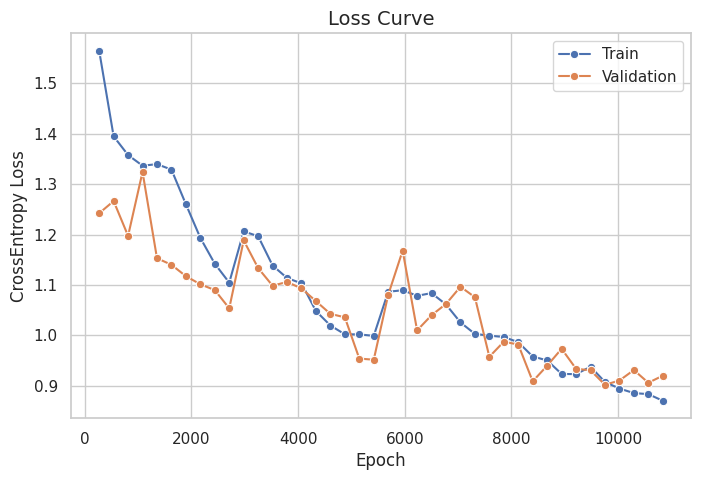

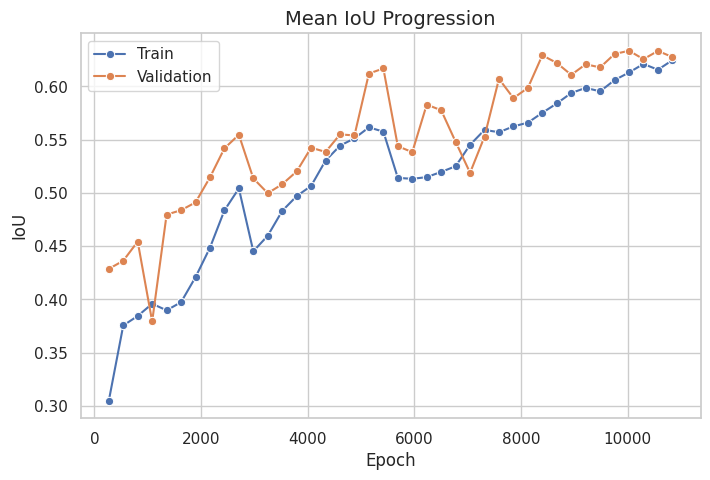

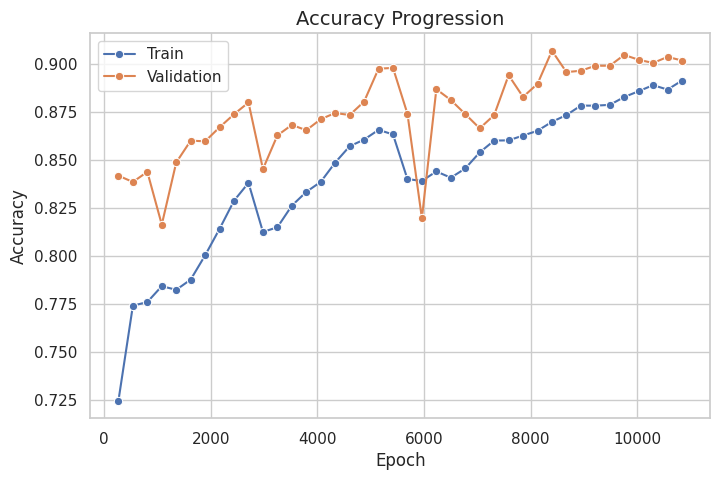

LR tags found: ['lr-AdamW']


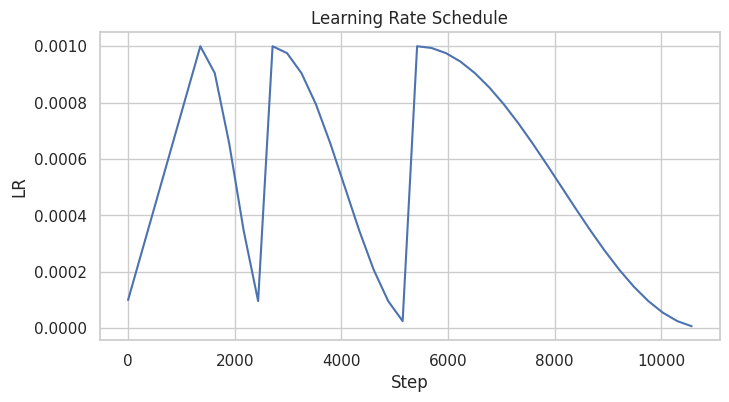

In [ ]:
# ============================================================
# Plot Training Curves for UNet-from-Scratch
# ============================================================

!pip install tensorboard-data-server tbparse --quiet

import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tbparse import SummaryReader

sns.set(style="whitegrid")

# ------------------------------------------------------------
# 1. Locate the correct lightning log directory
# ------------------------------------------------------------
logdirs = sorted(glob.glob("lightning_logs/*"))
assert len(logdirs) > 0, "No lightning_logs found."

print("Available log directories:")
for d in logdirs:
    print(" -", d)

logdir = logdirs[-1]   # pick latest run (UNet run)
print("\nUsing logdir:", logdir)

reader = SummaryReader(logdir, extra_columns={'dir_name'})
df = reader.scalars

print("\nMetrics detected:")
print(df["tag"].unique())

# ------------------------------------------------------------
# 2. Select only epoch-level metrics
# ------------------------------------------------------------
EPOCH_METRICS = [
    "train/loss",
    "val/loss",
    "train/iou",
    "val/iou",
    "train/acc",
    "val/acc"
]

df_epoch = df[df["tag"].isin(EPOCH_METRICS)].copy()

# Lightning logs step numbers, but we want epoch numbers
df_epoch["epoch"] = df_epoch["step"]


# ------------------------------------------------------------
# Helper plot function
# ------------------------------------------------------------
def plot_metric(tag_train, tag_val, title, ylabel):
    plt.figure(figsize=(8, 5))

    if tag_train in df_epoch.tag.values:
        sns.lineplot(
            data=df_epoch[df_epoch.tag == tag_train],
            x="epoch", y="value", marker="o", label="Train"
        )

    if tag_val in df_epoch.tag.values:
        sns.lineplot(
            data=df_epoch[df_epoch.tag == tag_val],
            x="epoch", y="value", marker="o", label="Validation"
        )

    plt.title(title, fontsize=14)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()


# ------------------------------------------------------------
# 3. Plot all key metrics
# ------------------------------------------------------------

# LOSS CURVE
plot_metric("train/loss", "val/loss", "Loss Curve", "CrossEntropy Loss")

# IOU CURVE
plot_metric("train/iou", "val/iou", "Mean IoU Progression", "IoU")

# ACCURACY CURVE
plot_metric("train/acc", "val/acc", "Accuracy Progression", "Accuracy")

# ------------------------------------------------------------
# 4. Plot Learning Rate Schedule (Cosine Annealing)
# ------------------------------------------------------------

lr_tags = [t for t in df["tag"].unique() if "lr" in t.lower()]

print("LR tags found:", lr_tags)

if len(lr_tags) > 0:
    lr_tag = lr_tags[0]
    plt.figure(figsize=(8,4))
    sns.lineplot(data=df[df.tag == lr_tag], x="step", y="value")
    plt.title("Learning Rate Schedule")
    plt.xlabel("Step")
    plt.ylabel("LR")
    plt.grid(True)
    plt.show()
else:
    print("⚠️ No learning rate logs found.")


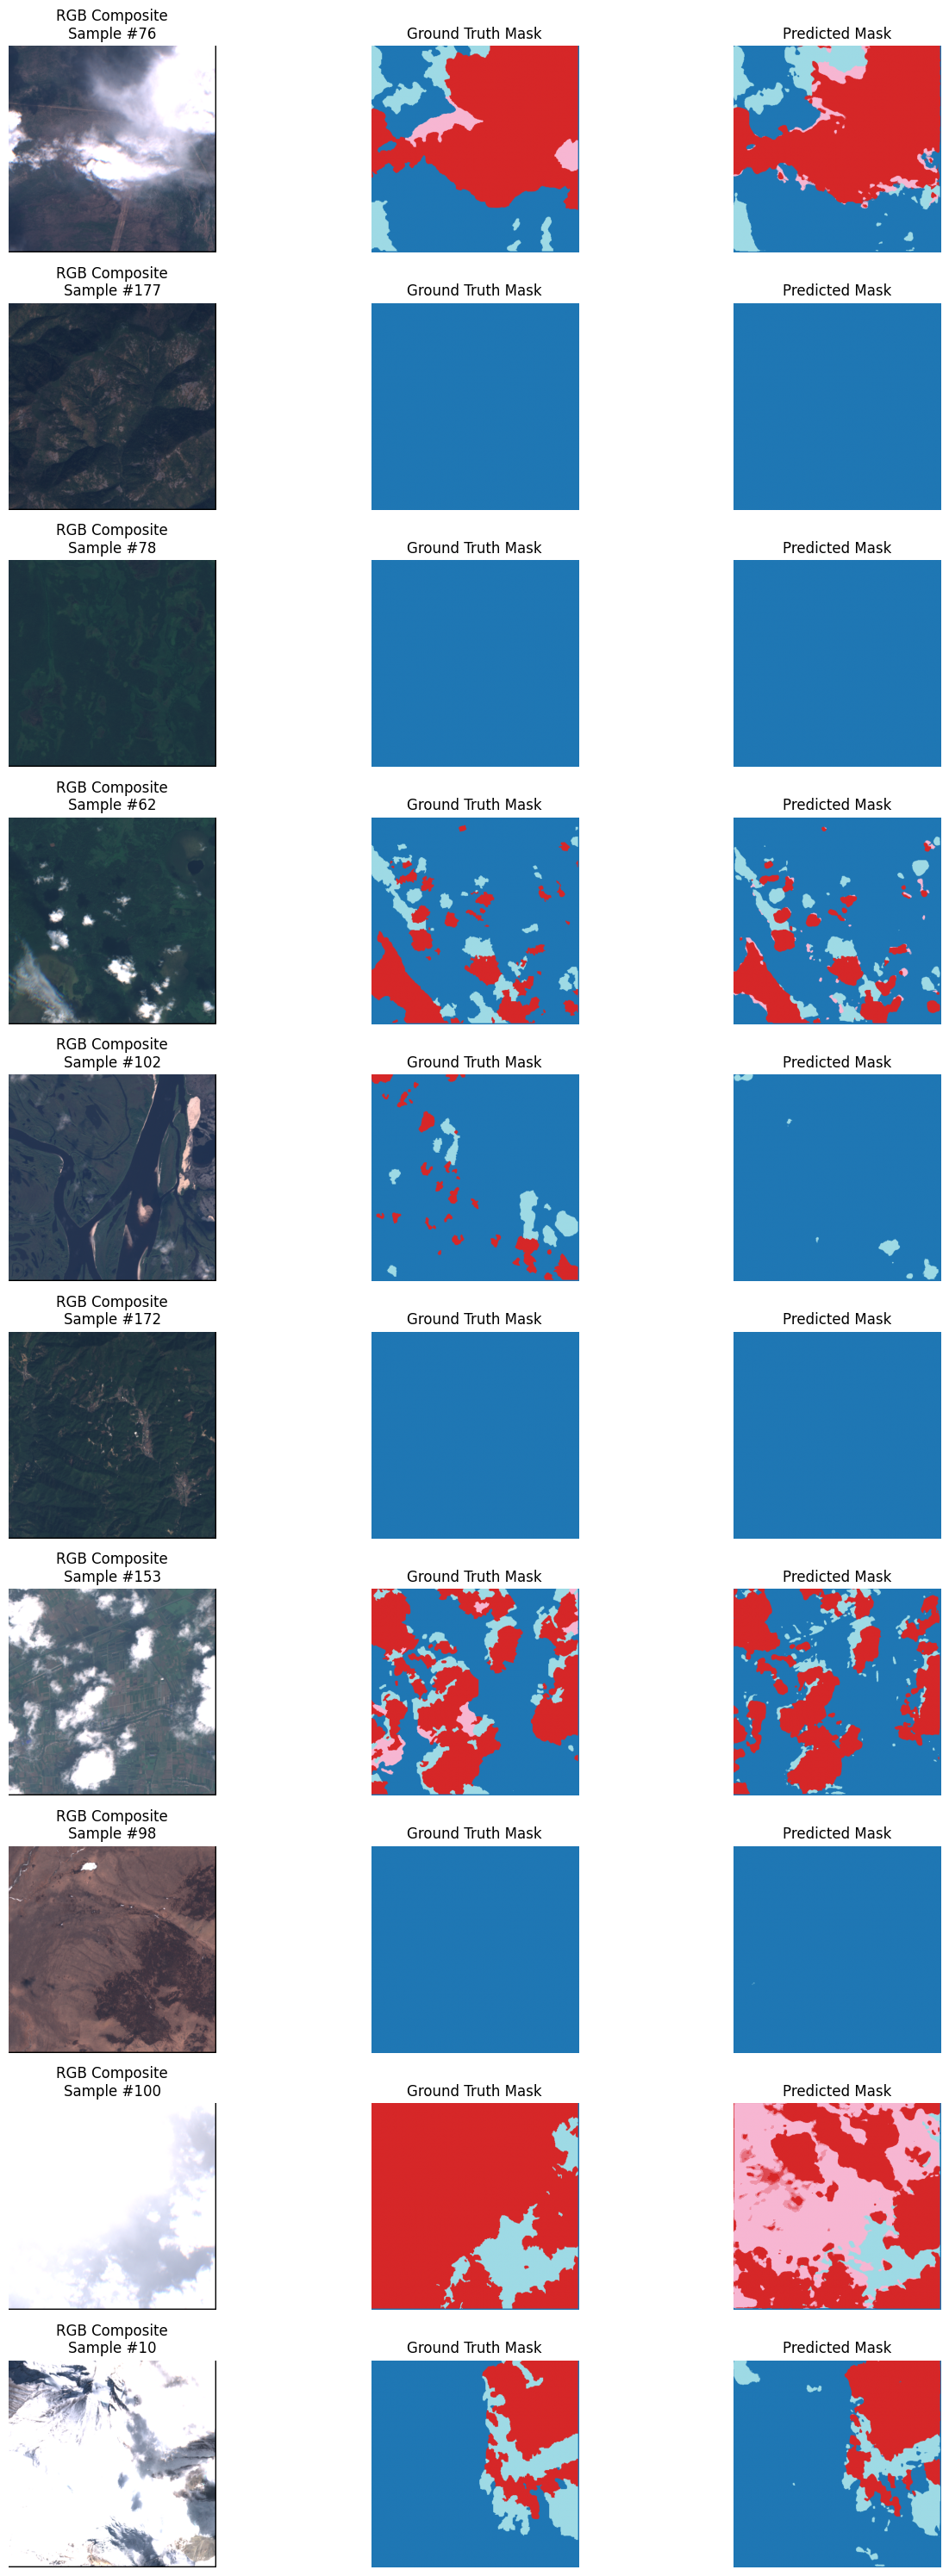

In [ ]:
# ============================================================
# VISUALIZE 10 RANDOM PREDICTIONS (UNet From Scratch)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import torch
import random

device = "cuda" if torch.cuda.is_available() else "cpu"
best_model = best_model.to(device)
best_model.eval()

# -------------------------------------------
# Select 10 random test samples
# -------------------------------------------
indices = random.sample(range(len(test_ds)), 10)

plt.figure(figsize=(14, 10 * 3))  # 3 rows per sample (RGB, GT, Pred)

row = 1

for idx in indices:

    # Load image + mask
    img, mask = test_ds[idx]
    img_t = img.unsqueeze(0).to(device)  # add batch dim
    mask_t = mask.to(device)

    # Model forward
    with torch.no_grad():
        logits = best_model(img_t)
        pred = logits.argmax(dim=1)[0]

    # -----------------------
    # RGB Composite (Bands 4,3,2)
    # -----------------------
    rgb = np.stack([
        img[3].numpy(),  # Red
        img[2].numpy(),  # Green
        img[1].numpy()   # Blue
    ], axis=-1)

    rgb = np.clip(rgb * 3.0, 0, 1)  # enhance visibility

    # -----------------------
    # Plotting
    # -----------------------
    # 1: RGB
    plt.subplot(10, 3, row)
    plt.imshow(rgb)
    plt.title(f"RGB Composite\nSample #{idx}", fontsize=12)
    plt.axis("off")

    # 2: Ground Truth
    plt.subplot(10, 3, row+1)
    plt.imshow(mask.numpy(), cmap="tab20")
    plt.title("Ground Truth Mask", fontsize=12)
    plt.axis("off")

    # 3: Prediction
    plt.subplot(10, 3, row+2)
    plt.imshow(pred.cpu().numpy(), cmap="tab20")
    plt.title("Predicted Mask", fontsize=12)
    plt.axis("off")

    row += 3

plt.tight_layout()
plt.show()
